In [47]:
from coralModel import Reef
from coralModel import Organism
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import tools as tl

from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

In [48]:
def finer(array, scale=3, rows=10, columns=10):
    columnCenter = 0
    rowCenter = 0
    columnCount = 0
    rowCount = 0

    fine = np.zeros((rows*scale,columns*scale))

    for r in range(0,rows*scale):
        for c in range(0,columns*scale):
            
            fine[r,c] = array[rowCenter, columnCenter]
            
            columnCount += 1
            if columnCount == scale:
                columnCenter += 1
                columnCount = 0
        rowCount += 1
        if rowCount == scale:
            rowCenter += 1
            rowCount = 0
        columnCenter = 0
        
    return(fine)

def initialFinal(data1, data2, title1="initial", title2="final"):
    fig, (ax, ax2, cax) = plt.subplots(1,3,        #subplot 3 to include color bar
     gridspec_kw={'width_ratios':[1,1, 0.05]})     #creates space allocated to each subplot
    fig.subplots_adjust(wspace=0.3)                #space btw subplots

    colors = ['pink', 'lightgreen','darkgreen']
    levels = [0, 1, 2]

    cmap, norm = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')

    im = ax.imshow(data1, cmap=cmap,norm=norm)
    im2 = ax2.imshow(data2,cmap=cmap,norm=norm)

    ip = InsetPosition(ax2, [1.05,0,0.05,1]) 
    cax.set_axes_locator(ip)

    fig.colorbar(im, cax=cax, ax=[ax,ax2])

    ax.set_title(title1)
    ax2.set_title(title2)
    plt.show()

def averageHists(x, coralCount, turfCount, algaeCount, ylabel):
    fig, (ax, ax2, ax3) = plt.subplots(1,3, facecolor = 'w', sharey='row')
    im = ax.bar(x, coralCount.mean(axis=1), color='pink')
    im2 = ax2.bar(x, turfCount.mean(axis=1), color='lightgreen')
    im2 = ax3.bar(x, algaeCount.mean(axis=1), color='darkgreen')
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time")
    ax2.set_xlabel("Time")
    ax3.set_xlabel("Time")
    ax.set_facecolor('white')
    ax2.set_facecolor('white')
    ax3.set_facecolor('white')
    plt.show()
    
def timeSeries(x, x1,x2,x3,legend1='Coral', legend2='Turf', legend3='Algae'):
    fig1 = plt.figure()
    x = np.arange(NumberOfRuns)
    im = plt.plot(x, coralCount[:,1], color='pink')
    im2 = plt.plot(x, turfCount[:,1], color='lightgreen')
    im2 = plt.plot(x, algaeCount[:,1], color='darkgreen')
    plt.legend(['Coral', 'Turf', 'Algae'], loc='upper left', fontsize = 'medium')
    plt.ylabel("Percent")
    plt.xlabel("Time")
    plt.show()



In [126]:
#Set Parameters
coralPercent = .4
algaePercent = .3
turfPercent = 1 - coralPercent - algaePercent
r=1.0
d=.4
a=.2
g=.8
y=.75
dt=.01
tf=10
NumberOfRuns = int(tf/dt)
NumberOfSimulations = 2
rows = 20
columns = 20

NumberOfNodes = rows * columns
coralCount = np.zeros((NumberOfRuns, NumberOfSimulations))
turfCount = np.zeros((NumberOfRuns, NumberOfSimulations))
algaeCount = np.zeros((NumberOfRuns, NumberOfSimulations))
types = np.zeros((NumberOfRuns, NumberOfNodes, NumberOfSimulations))

In [127]:
int(tf/dt)

1000

In [128]:
#Generate square 8x8 reef with randomly assigned types
#0 = Coral, 1 = Turf, 2 = Algae
Moorea = Reef()
count = 0
for i in range(0,rows):
    for j in range(0, columns):
        U = np.random.choice([0,1,2],
                             p=[coralPercent, turfPercent, algaePercent])
        node = Organism(type=U, location=[i,j], ID=count)
        Moorea.append(node)
        count = count + 1
Moorea.generateGraph()


In [129]:
#Run model 
for s in range(0,NumberOfSimulations):    
    for n in range(0,NumberOfRuns):
        for i,val in enumerate(Moorea.nodes):
            types[n,i,s] = Moorea.nodes[i].type
        coralCount[n,s] = np.count_nonzero(types[n,:,s] == 0)
        turfCount[n,s] = np.count_nonzero(types[n,:,s] == 1)
        algaeCount[n,s] = np.count_nonzero(types[n,:,s] == 2)
        Moorea.roll(r=r, d=d, a=a, g=g, y=y, dt=dt)

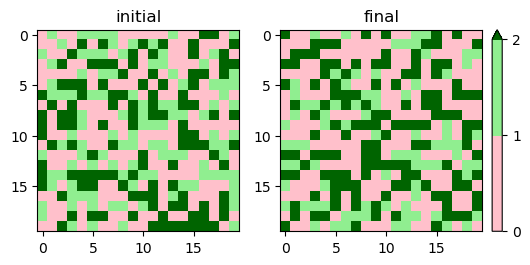

In [130]:
#Plotting inital and last spatial distribution of model runs
data1 = np.reshape(types[0,:,0], (-1, rows))
data2 = np.reshape(types[NumberOfRuns-1,:,0], (-1, rows))
initialFinal(data1=data1, data2=data2)                   

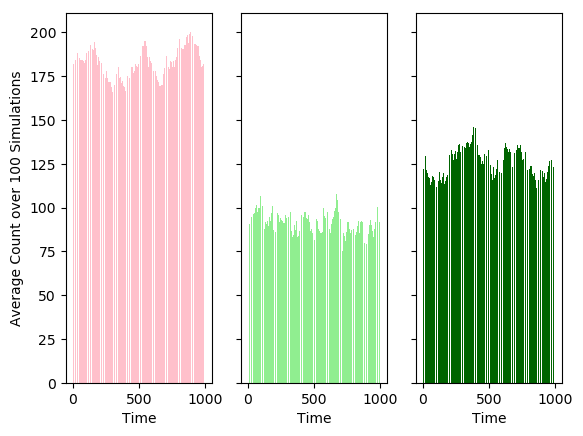

In [147]:
#Plotting histograms
x = np.arange(NumberOfRuns)
ylabel = "Average Count over 100 Simulations"
averageHists(x, coralCount, turfCount, algaeCount, ylabel) 

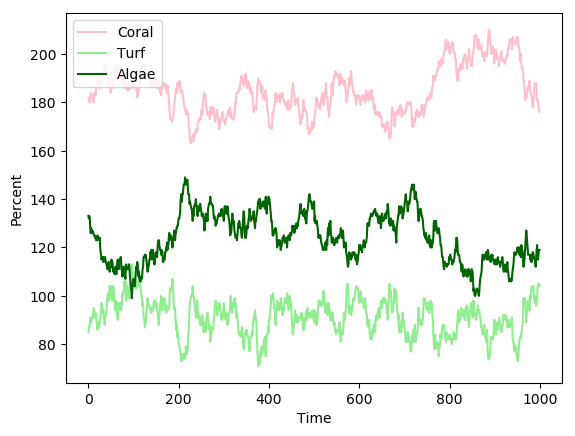

In [134]:
#Plotting progression over time for 1 simulation
x1=coralCount[:,1]
x2=turfCount[:,1]
x3=algaeCount[:,1]
timeSeries(x, x1,x2,x3)

# Begin TDA

#### Steps
* Set values to 1 = Coral, 0 = Other
* create a finer grid
* use gaussians at each node to create variation based on overlap
* Do TDA on output 


Proximity of Patches less relevant? looking at neighbour relations, not global

In [146]:
types.shape

(1000, 400, 2)

In [150]:
def binaryizer(df):
    df[df>0] = 3
    df[df == 0] = 1
    df[df == 3] = 0
    return(df)
    
def shaper(df, rows):
    df = np.reshape(df, (-1, rows))
    return(df)

def finer(df, rows=10, columns=10, scale=3):
    columnCenter, rowCenter = 0, 0
    columnCount, rowCount = 0, 0
    fine = np.zeros((rows*scale,columns*scale))
    for r in range(0,rows*scale):
        for c in range(0,columns*scale):            
            fine[r,c] = df[rowCenter, columnCenter]           
            columnCount += 1
            if columnCount == scale:
                columnCenter += 1
                columnCount = 0
        rowCount += 1
        if rowCount == scale:
            rowCenter += 1
            rowCount = 0
        columnCenter = 0 
    return(fine)

def tda_prep(df, columns, rows, fineness, refined_grid = True):
    df = binaryizer(df)
    df = shaper(df,rows)
    if refined_grid == True:
        df = finer(df, rows, columns, scale = fineness)
    return(df)

In [163]:
#saved = types
test1 = types[3,:,1]
test2 = types[NumberOfRuns-1,:,0]

In [169]:
saved[3,:,1]

array([0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
       1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 1.

In [170]:
tda_prep(test1, columns, rows, 2, True)

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       ...,
       [0., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 1., 0., 0.]])

In [132]:
data1.shape[1]

20

In [104]:
data1.shape[0]

8

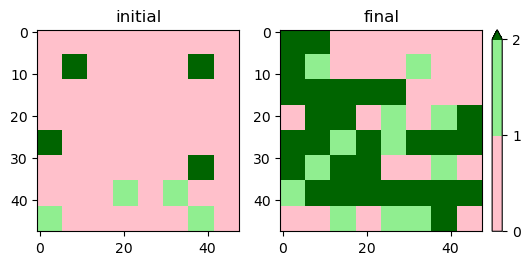

In [56]:
initialFinal(data1=df1, data2=df2)  

In [99]:
from ripser import lower_star_img
from persim import plot_diagrams

In [101]:
dmg = lower_star_img(df2)[dmg]

IndexError: arrays used as indices must be of integer (or boolean) type

In [100]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(df2)
plt.colorbar()
plt.title("Test Image")
plt.subplot(122)
plot_diagrams(dgm)
plt.title("0-D Persistence Diagram")
plt.tight_layout()
plt.show()

##super level set filtration h0 fast, h1, slower. super level set.  
#H1 = Flip

NameError: name 'dgm' is not defined

In [71]:
binaryizer(df2)

In [72]:
df2

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [85]:
import cv2

output persistant diagrams: 

SyntaxError: invalid syntax (<ipython-input-85-8b12873a9c67>, line 3)

In [68]:
from scipy import ndimage
ndimage.distance_transform_edt(df1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [4., 4., 4., ..., 0., 0., 0.],
       [5., 5., 4., ..., 0., 0., 0.],
       [6., 5., 4., ..., 0., 0., 0.]])

In [84]:
?ndimage.distance_transform_edt()

Signature: ndimage.distance_transform_edt(input, sampling=None, return_distances=True, return_indices=False, distances=None, indices=None)
Docstring:
Exact euclidean distance transform.

In addition to the distance transform, the feature transform can
be calculated. In this case the index of the closest background
element is returned along the first axis of the result.

Parameters
----------
input : array_like
    Input data to transform. Can be any type but will be converted
    into binary: 1 wherever input equates to True, 0 elsewhere.
sampling : float or int, or sequence of same, optional
    Spacing of elements along each dimension. If a sequence, must be of
    length equal to the input rank; if a single number, this is used for
    all axes. If not specified, a grid spacing of unity is implied.
return_distances : bool, optional
    Whether to return distance matrix. At least one of
    return_distances/return_indices must be True. Default is True.
return_indices : bool, optional

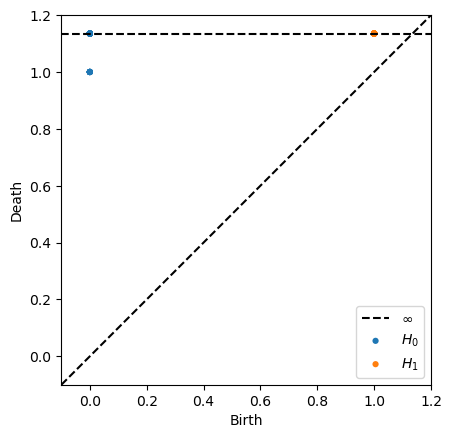

In [82]:
## Do TDA on output
from ripser import ripser
from persim import plot_diagrams
diagrams = ripser(df1,distance_matrix=True)['dgms']
plot_diagrams(diagrams, show=True)
#diagrams <- output in array form

In [86]:
dgm = lower_star_img(-cells_grey)

plt.figure(figsize=(6, 6))
plot_dgms(dgm, lifetime=True)
plt.show()

NameError: name 'lower_star_img' is not defined

In [80]:
ripser(df1)['cocycles']

/Users/rosannaneuhausler/anaconda/lib/python3.6/site-packages/ripser/ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  + "this was a distance matrix?"


[[], []]

In [78]:
?ripser()

Signature: ripser(X, maxdim=1, thresh=inf, coeff=2, distance_matrix=False, do_cocycles=False, metric='euclidean', n_perm=None)
Docstring:
Compute persistence diagrams for X data array. If X is not a distance matrix, it will be converted to a distance matrix using the chosen metric.

Parameters
----------
X: ndarray (n_samples, n_features)
    A numpy array of either data or distance matrix.
    Can also be a sparse distance matrix of type scipy.sparse

maxdim: int, optional, default 1
    Maximum homology dimension computed. Will compute all dimensions 
    lower than and equal to this value. 
    For 1, H_0 and H_1 will be computed.

thresh: float, default infinity
    Maximum distances considered when constructing filtration. 
    If infinity, compute the entire filtration.

coeff: int prime, default 2
    Compute homology with coefficients in the prime field Z/pZ for p=coeff.

distance_matrix: bool
    Indicator that X is a distance matrix, if not we compute a 
    distance matrix f

In [73]:
diagrams

[array([[0.        , 2.44948983],
        [0.        , 2.44948983],
        [0.        , 2.44948983],
        [0.        , 2.44948983],
        [0.        , 3.46410155],
        [0.        ,        inf]]), array([[2.44948983, 3.46410155]])]